# Neural Networks in ``PyTorch``- Starcraft 2 Dataset

Le dataset contient plusieurs replay de match 1 contre 1 du jeu Starcraft2.
Pour chaque replay est enregistré à chaque temps T l'etat du jeu et le gagnant à la fin

<img src="files/figures/sc2_logo.png" width="600px"/>

Nous allons définir et entrainer un réseau de neuronnes sur ce dataset. C'est un problème de classification.<br>

The definition and training of a neural network invoves the following steps:

0. Import **librairies**;
1. Get the **datasets** (train, validation and test);
2. Define the **dataloaders** from the datasets (train and test);
3. Define the **model**;
4. Define the **loss function**;
5. Define the **optimizer**;
7. **Train** the model (training loop);
8. Get the **results** (predict).

## 0. Librairies

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

## 1. Exploration du Dataset

In [2]:
train = pd.read_csv('archive/trainSet3.csv')
test = pd.read_csv('archive/testSet3.csv')
train.head(10)

,time,race1,race2,supplyUsed1,supplyUsed2,supplyMade1,supplyMade2,totalIncome1,totalIncome2,mineralsIncome1,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,7,1,2,13.0,13.0,14.0,15.0,251,251,251,...,0,12,12,0,0,0,0,0,0,0
1,14,1,2,13.0,14.0,14.0,15.0,671,671,671,...,0,13,13,0,0,0,0,0,0,0
2,21,1,2,14.0,14.0,14.0,15.0,727,671,727,...,0,13,13,0,0,0,0,0,0,0
3,29,1,2,14.0,15.0,14.0,15.0,755,671,755,...,0,13,14,0,0,0,0,0,0,0
4,36,1,2,16.0,15.0,22.0,15.0,755,755,755,...,0,14,15,0,0,0,0,0,0,0
5,43,1,2,16.0,16.0,22.0,23.0,783,783,783,...,0,14,15,0,0,0,0,0,0,0
6,50,1,2,16.0,17.0,22.0,23.0,811,727,811,...,0,16,16,0,0,0,0,0,0,0
7,57,1,2,17.0,17.0,22.0,23.0,839,755,839,...,0,15,16,0,0,0,0,0,0,0
8,64,1,2,18.0,18.0,22.0,23.0,867,895,867,...,0,15,17,0,0,0,0,0,0,0
9,71,1,2,17.0,19.0,22.0,23.0,895,923,895,...,0,16,18,0,0,0,0,0,0,0


In [3]:
test.head(10)

,time,race1,race2,supplyUsed1,supplyUsed2,supplyMade1,supplyMade2,totalIncome1,totalIncome2,mineralsIncome1,...,vespene2,activeWorkers1,activeWorkers2,army1,army2,technology1,technology2,lostResources1,lostResources2,winner
0,7,0,1,13.0,13.0,15.0,14.0,167,293,167,...,0,12,12,0,0,0,0,0,0,0
1,14,0,1,14.0,14.0,15.0,14.0,671,587,671,...,0,13,12,0,0,0,0,0,0,0
2,21,0,1,14.0,15.0,15.0,14.0,699,727,699,...,0,13,14,0,0,0,0,0,0,0
3,29,0,1,15.0,15.0,15.0,14.0,699,671,699,...,0,14,14,0,0,0,0,0,0,0
4,36,0,1,15.0,15.0,15.0,14.0,699,727,699,...,0,14,15,0,0,0,0,0,0,0
5,43,0,1,16.0,14.0,23.0,14.0,755,727,755,...,0,15,14,0,0,0,0,0,0,0
6,50,0,1,16.0,15.0,23.0,14.0,727,727,727,...,0,15,14,0,0,0,0,0,0,0
7,57,0,1,17.0,15.0,23.0,14.0,727,699,727,...,0,16,14,0,0,0,0,0,0,0
8,64,0,1,17.0,14.0,23.0,14.0,755,699,755,...,0,16,14,0,0,0,0,0,0,0
9,71,0,1,18.0,14.0,23.0,14.0,755,699,755,...,0,17,14,0,0,0,0,0,0,0


In [4]:
print(train['winner'].unique())
print(test['winner'].unique())

[0 1]
[0 1]


In [5]:
## Liste l'ensemble des colonnes avec le type des données et le nombre de valeurs non-nulles de chaque colonne
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730419 entries, 0 to 730418
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             730419 non-null  int64  
 1   race1            730419 non-null  int64  
 2   race2            730419 non-null  int64  
 3   supplyUsed1      730419 non-null  float64
 4   supplyUsed2      730419 non-null  float64
 5   supplyMade1      730419 non-null  float64
 6   supplyMade2      730419 non-null  float64
 7   totalIncome1     730419 non-null  int64  
 8   totalIncome2     730419 non-null  int64  
 9   mineralsIncome1  730419 non-null  int64  
 10  mineralsIncome2  730419 non-null  int64  
 11  vespeneIncome1   730419 non-null  int64  
 12  vespeneIncome2   730419 non-null  int64  
 13  totalResources1  730419 non-null  int64  
 14  totalResources2  730419 non-null  int64  
 15  minerals1        730419 non-null  int64  
 16  minerals2        730419 non-null  int6

In [6]:
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362837 entries, 0 to 362836
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             362837 non-null  int64  
 1   race1            362837 non-null  int64  
 2   race2            362837 non-null  int64  
 3   supplyUsed1      362837 non-null  float64
 4   supplyUsed2      362837 non-null  float64
 5   supplyMade1      362837 non-null  float64
 6   supplyMade2      362837 non-null  float64
 7   totalIncome1     362837 non-null  int64  
 8   totalIncome2     362837 non-null  int64  
 9   mineralsIncome1  362837 non-null  int64  
 10  mineralsIncome2  362837 non-null  int64  
 11  vespeneIncome1   362837 non-null  int64  
 12  vespeneIncome2   362837 non-null  int64  
 13  totalResources1  362837 non-null  int64  
 14  totalResources2  362837 non-null  int64  
 15  minerals1        362837 non-null  int64  
 16  minerals2        362837 non-null  int6

Création des classes Data et Data_Test pour créer l'ensemble d'apprentissage et l'ensemble de test
Ces classes s'occupe également du préprocessing : par exemple le dataset brut contient la colonne satosfaction qui peut prendre deux valeurs : "satisfait" ou "non satisfait". On encode donc comme suit : 0 pour non satisfait et 1 pour satisfait

In [7]:
class Data(Dataset):
    def __init__(self):
        train = pd.read_csv('archive/trainSet3.csv')
        x = train.drop("winner", axis=1)
        x = x.astype(np.float32)
        self.x_train = torch.tensor(x.values)
        y = train["winner"]
        y = y.astype(np.float32)
        self.y_train = torch.tensor(y.values)
        self.n_samples = train.shape[0]
    
    def __getitem__(self,index):
        return self.x_train[index],self.y_train[index]
    
    def __len__(self):
        return self.n_samples

In [8]:
class Data_test(Dataset):
    def __init__(self):
        test = pd.read_csv('archive/testSet3.csv')
        test.replace([np.inf, -np.inf], np.nan, inplace=True)
        x = test.drop("winner", axis=1)
        x = x.astype(np.float32)
        self.x_test = torch.tensor(x.values)
        y = test["winner"]
        y = y.astype(np.float32)
        self.y_test = torch.tensor(y.values)
        self.n_samples = test.shape[0]
    
    def __getitem__(self,index):
        return self.x_test[index],self.y_test[index]
    
    def __len__(self):
        return self.n_samples

In [9]:
train_dataset = Data()
test_dataset = Data_test()

In [10]:
print(train.columns)
print(train.shape)

Index(['time', 'race1', 'race2', 'supplyUsed1', 'supplyUsed2', 'supplyMade1',
       'supplyMade2', 'totalIncome1', 'totalIncome2', 'mineralsIncome1',
       'mineralsIncome2', 'vespeneIncome1', 'vespeneIncome2',
       'totalResources1', 'totalResources2', 'minerals1', 'minerals2',
       'vespene1', 'vespene2', 'activeWorkers1', 'activeWorkers2', 'army1',
       'army2', 'technology1', 'technology2', 'lostResources1',
       'lostResources2', 'winner'],
      dtype='object')
(730419, 28)


In [11]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([27]), tensor(0.))

In [12]:
test_dataset[0][0].shape, test_dataset[0][1]

(torch.Size([27]), tensor(0.))

In [13]:
len(train_dataset)

730419

In [14]:
len(test_dataset)

362837

On créer un ensemble de validation a partir de l'ensemble d'apprentissage

In [15]:
train_dataset, val_dataset = random_split(train_dataset, [584419,146000])

In [16]:
len(train_dataset), len(val_dataset), len(test_dataset)

(584419, 146000, 362837)

## 2. Dataloaders

A **dataloader** creates batches of samples from a dataset so that they can be passed into a model.
- Create a train and test dataloaders using the following commands:
```
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
```
- Note that dataloaders are not subscriptable.
- Try to catch one batch of the dataloader and examine it.
- Write a function that reshapes a batch of size $64 \times 1 \times 28 \times 28$ into a tensor of size $64 \times 784$.<br>
(use `torch.squeeze()`, `torch.reshape()`, `torch.flatten()`, `torch.transpose()`, etc.)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [18]:
def reshape_batch(batch):
    
    # note that this function moodifies the batch in-place (no return)
    batch_size = batch[0].shape[0]
    batch[0] = batch[0].view(batch_size, -1)
    
    return batch

In [19]:
for b in train_dataloader:
    break

In [20]:
b[0].shape

torch.Size([128, 27])

In [21]:
reshape_batch(b)

[tensor([[1.0360e+03, 2.0000e+00, 1.0000e+00,  ..., 2.8500e+03, 1.2825e+04,
          1.2612e+04],
         [2.2900e+02, 0.0000e+00, 2.0000e+00,  ..., 8.5000e+02, 0.0000e+00,
          0.0000e+00],
         [7.5000e+02, 1.0000e+00, 0.0000e+00,  ..., 3.9000e+03, 5.3100e+02,
          0.0000e+00],
         ...,
         [6.4000e+01, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.7100e+02, 1.0000e+00, 2.0000e+00,  ..., 2.2000e+03, 1.1250e+03,
          2.8750e+03],
         [4.1400e+02, 0.0000e+00, 0.0000e+00,  ..., 8.2500e+02, 1.7000e+03,
          1.3860e+03]]),
 tensor([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0

In [22]:
b[0].shape

torch.Size([128, 27])

## 3. Model

- Define and instanciate a **neural network** with the following feaures:
    - hidden layer 1: 256 neurons, relu activation function
    - hidden layer 2: 256 neurons, relu activation function
    - hidden layer 3: 128 neurons, relu activation function
    - hidden layer 4: 64 neurons, relu activation function
    - output layer: 10 neurons

In [23]:
class Network(nn.Module):

    def __init__(self):
        
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(27, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
        

    def forward(self, x):
        
        x = self.fc1(x)
        x = nn.ReLU()(x) #fonction d'activation
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        
        x = self.fc3(x)
        x = nn.ReLU()(x)
        
        x = self.fc4(x)
        x = nn.ReLU()(x)
        
        x = self.fc5(x)
        
        
        
        return x

In [24]:
network = Network()

In [25]:
# Put network to GPU if exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

In [26]:
network

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

## 4. Loss

- Define a **cross entropy loss** with the following command:<br>
```
loss = nn.CrossEntropyLoss()
```
- Try to understand this loss object:<br>
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [27]:
loss = nn.CrossEntropyLoss()

## 5. Optimizer

- Define an **SGD optimizer** with the following command:<br>
```
optimizer = torch.optim.SGD(network.parameters(), lr=0.005)
```
- Try to understand this object:<br>
https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

On peut faire varier le learning rate lr

In [28]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)

## 6. Training

- Define a **training loop** for you model.
- The key instructions are:
    - ``optimizer.zero_grad()``: reset gradients to 0
    - ``loss.backward()``      : compute new gradients
    - ``optimizer.step()``     : uptdate weights
- Train the model for 20 epochs.
- Plot the training loss.

In [29]:
def train(model, loss=None, optimizer=None, train_dataloader=None, val_dataloader=None, nb_epochs=20):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):

        # Training
        train_loss = 0.0

        for data, labels in train_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)   # casting to long
                data, labels = data.to(device), labels.to(device)
                
            
            # Reset gradients to 0
            optimizer.zero_grad()

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute training loss
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Compute gradients
            current_loss.backward()

            # Update weights
            optimizer.step()
        
        # Validation
        val_loss = 0.0

        # Put model in eval mode
        model.eval()

        for data, labels in val_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)   # casting to long
                data, labels = data.to(device), labels.to(device)

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute validation loss
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()
        
        # Prints
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")
        
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Save model if val loss decreases
        if val_loss < min_val_loss:

            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            
    return train_losses, val_losses

In [30]:
train_losses, val_losses = train(model=network, loss=loss, optimizer=optimizer, 
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                                 nb_epochs=20)

Epoch 1/20                 	 Training Loss: 0.652                 	 Validation Loss: 0.564
Epoch 2/20                 	 Training Loss: 0.563                 	 Validation Loss: 0.566
Epoch 3/20                 	 Training Loss: 0.557                 	 Validation Loss: 0.554
Epoch 4/20                 	 Training Loss: 0.552                 	 Validation Loss: 0.550
Epoch 5/20                 	 Training Loss: 0.548                 	 Validation Loss: 0.545
Epoch 6/20                 	 Training Loss: 0.544                 	 Validation Loss: 0.544
Epoch 7/20                 	 Training Loss: 0.541                 	 Validation Loss: 0.545
Epoch 8/20                 	 Training Loss: 0.538                 	 Validation Loss: 0.539
Epoch 9/20                 	 Training Loss: 0.535                 	 Validation Loss: 0.539
Epoch 10/20                 	 Training Loss: 0.533                 	 Validation Loss: 0.538
Epoch 11/20                 	 Training Loss: 0.530                 	 Validation Loss: 0.5

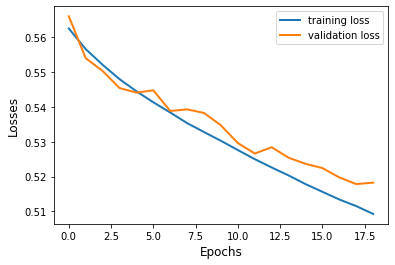

In [31]:
# Plot losses
plt.plot(range(len(train_losses[1:])), train_losses[1:], 
         linewidth=2.0, 
         label='training loss')

plt.plot(range(len(val_losses[1:])), val_losses[1:], 
         linewidth=2.0, 
         label='validation loss')

plt.xlabel("Epochs", size=12)
plt.ylabel("Losses", size=12)
plt.legend()

plt.savefig('figures/losses.pdf') 
plt.show()

## 6. Testing

- Write a ``predict`` function
    - use ``with torch.no_grad():``
- Compute the accuracy and classification report of the train and test sets.

In [32]:
def predict(model, test_dataloader):

    labels_l = []
    preds_l = []
    
    # Put model in eval mode
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloader):
            
            data, labels = reshape_batch(batch)
            data, labels = data.to(device), labels.to(device) #sinon bug
            
            labels_l.extend(labels.tolist())
            
            preds = model.to(device)
            preds = model(data)
            
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [33]:
train_labels, train_preds = predict(network, train_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [34]:
print(classification_report(train_labels, train_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6967    0.7900    0.7404    307298
         1.0     0.7265    0.6186    0.6682    277121

    accuracy                         0.7087    584419
   macro avg     0.7116    0.7043    0.7043    584419
weighted avg     0.7108    0.7087    0.7062    584419



In [35]:
print(classification_report(test_labels, test_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6474    0.7352    0.6885    191173
         1.0     0.6527    0.5540    0.5993    171664

    accuracy                         0.6495    362837
   macro avg     0.6500    0.6446    0.6439    362837
weighted avg     0.6499    0.6495    0.6463    362837



## 7. Save

- Save your trained model.
- Try to reload it and see if it works.
- Use the following instructions
```
torch.save(model.state_dict(), <path>)
...
network_2.load_state_dict(torch.load(<path>))
network_2.eval()
```

In [36]:
cwd = os.getcwd()
path = os.path.join(cwd, "model.pt")
path_2 = os.path.join(cwd, "best_model.pt")

In [37]:
# Save last model
torch.save(network.state_dict(), path) 

In [38]:
# Load best model
network_2 = Network()

network_2.load_state_dict(torch.load(path))
network_2.eval()

Network(
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

In [39]:
test_labels, test_preds = predict(network_2, test_dataloader)

In [40]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.74      0.69    191173
         1.0       0.65      0.55      0.60    171664

    accuracy                           0.65    362837
   macro avg       0.65      0.64      0.64    362837
weighted avg       0.65      0.65      0.65    362837

